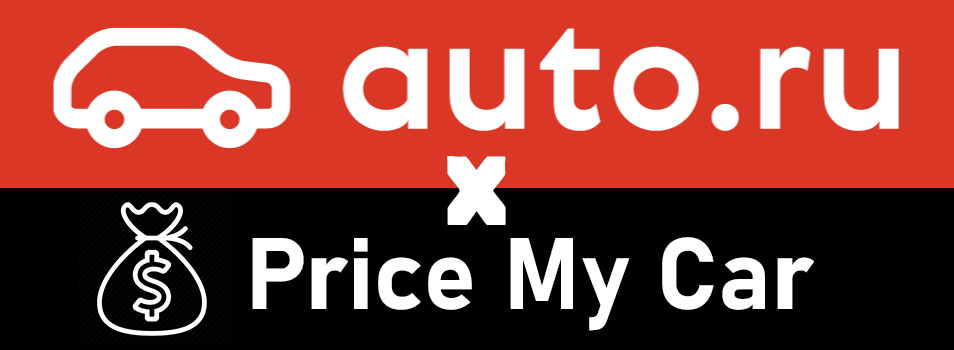

<h1><center>Welcome to the Price My Car!</center></h1>


This is regression model, that you can depend on when you want to sell your car or buy a new one.

-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

<div style="text-align: right"> Training data is gaining from a popular auto marketplace in Russia named "Auto.ru"</div>
<div style="text-align: right"> this is a project of one of the biggest company in Russian Federation names "Yandex"</div>

-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------



<h1><center>Data Loading from "auto.ru"</center></h1>

In [1]:
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
import warnings
from bs4 import BeautifulSoup
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

warnings.filterwarnings('ignore')

training_data = pd.read_csv('training_data.csv')

<h1><center>Data Preprocessing, Explaration and Spliting</center></h1>

Данные загружены. Необходимо исследовать их и подготовить к обучению.

In [2]:
training_data['Цена (рубли)'] = training_data['Цена (рубли)'].replace('Not price rub', np.nan)
training_data['Цена (рубли)'] = training_data['Цена (рубли)'].astype(float)
training_data['Количество владельцев'] = training_data['Количество владельцев'].replace('The number of owners is not specified', np.nan)
training_data['Количество владельцев'] = training_data['Количество владельцев'].astype(float)

corr = training_data.corr()
corr['Цена (рубли)'].sort_values(ascending=False)[1:10].to_frame().style.background_gradient(axis=1,cmap=sns.light_palette('green', as_cmap=True))

,Цена (рубли)
Год,0.459131
Количество дверей,0.071090
Координаты_ширина,0.030712
Координаты_долгота,-0.039036
Количество владельцев,-0.304978
Пробег,-0.463563
Таможня,nan


В большей степени на цену оказывают влияние следующие параметры:
<b>
1. Пробег


    
2. Год выпуска


3. Количество владельцев</b>

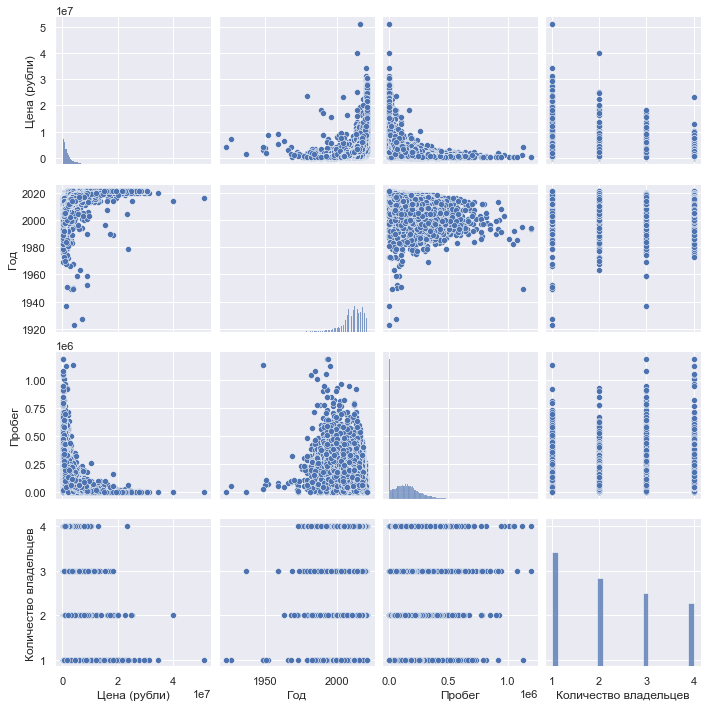

In [3]:
cols = ['Цена (рубли)', 'Год', 'Пробег', 'Количество владельцев']
sns.set()
sns.pairplot(training_data[cols],size=2.5)
plt.show();

Также на графиках мы можем наблюдать зависимость цены от основных признаков.

<b>На данный момент модель принимает для обучения следующие признаки:</b>
<i>
- 'Цвет' - цвет автомобиля 

- 'Количество владельцев' - кол-во владельцев по ПТС

- 'Год' - год выпуска автомобиля

- 'С салона' - автомобиль от салона или от собственника

- 'Регион' - регион продажи автомобиля

- 'Пробег' - пробег в км. 

- 'Секция' - новый или б/у 

- 'Производитель' - страна производства

- 'Имя_автомобиля' - тип кузова

- 'Марка_автомобиля' - марка

- 'Модель автомобиля' - модель

- 'Цена (рубли)' - цена</i>

Для категориальных значений применяется техника <b>One Hot Encoding</b>

После обработки категориальных значений во избежании ошибок при обучении модели убираются специальные символы JSON.

Удаляются автомобили, у которых не проставлена Цена.

In [4]:
training_data = training_data.reset_index(drop=True)
df_auto = training_data

data_auto = df_auto[['Цвет', 'Количество владельцев', 'Год', 'С салона', 'Регион', 'Пробег', 'Секция',
                    'Производитель', 'Имя_автомобиля', 'Марка_автомобиля', 'Модель автомобиля', 'Цена (рубли)']]
data_auto = data_auto.drop_duplicates().reset_index(drop=True)
data_auto.columns = ['color', 'owners', 'year', 'dealer', 'region', 'mileage', 'section', 'vendor', 'body_type', 'mark', 'model', 'price']

print('Размер общих данных до обработки: {} строк, {} столбцов'.format(data_auto.shape[0], data_auto.shape[1]))
print('-'*90)

data_auto = pd.get_dummies(data_auto, columns=['color', 'dealer', 'region', 'section', 'vendor', 'body_type', 'mark', 'model'])

print('Размер общих данных после обработки: {} строк, {} столбцов'.format(data_auto.shape[0], data_auto.shape[1]))
print('-'*90)

data_auto['price'] = data_auto['price'].replace('Not price rub', np.nan)
data_auto = data_auto.dropna(axis=0)

print('Размер общих данных после удаления пропусков: {} строк, {} столбцов'.format(data_auto.shape[0], data_auto.shape[1]))
print('-'*90)

for arg in [',',']','[','{','}','"',':']:
    data_auto.columns = [x.replace(arg, '') for x in data_auto.columns]

Размер общих данных до обработки: 46858 строк, 12 столбцов
------------------------------------------------------------------------------------------
Размер общих данных после обработки: 46858 строк, 1403 столбцов
------------------------------------------------------------------------------------------
Размер общих данных после удаления пропусков: 36062 строк, 1403 столбцов
------------------------------------------------------------------------------------------


На данном этапе производится разделение данных на обучающую, валидационную и тестовую выборку.

In [5]:
features = data_auto.drop('price', axis=1)
target = data_auto['price']

In [6]:
features_train, features_remain, target_train, target_remain = train_test_split(features, target, train_size=0.6,
                                                                               random_state=12345)
features_valid, features_test, target_valid, target_test = train_test_split(features_remain, target_remain, train_size=0.5,
                                                                               random_state=12345)

Далее проивзодится <b>масштабирование данных</b> с помощью <b>Standard Scaler</b>

In [7]:
features_train['owners'] = features_train['owners'].replace('The number of owners is not specified', 0)
features_valid['owners'] = features_valid['owners'].replace('The number of owners is not specified', 0)
features_test['owners'] = features_test['owners'].replace('The number of owners is not specified', 0)

num_cols = ['owners', 'year', 'mileage']

scaler = StandardScaler()
scaler.fit(features_train[num_cols])
features_train[num_cols] = scaler.transform(features_train[num_cols])
features_valid[num_cols] = scaler.transform(features_valid[num_cols])
features_test[num_cols] = scaler.transform(features_test[num_cols])

features_train.head()

,owners,year,mileage,color_0000CC,color_007F00,color_040001,color_200204,color_22A0F8,color_4A2197,color_660099,...,model_i-MiEV,model_i10,model_i20,model_i3,model_i30,model_i30 N,model_i40,model_iQ,model_ix35,model_ix55
11607,0.676187,1.150640,-0.815438,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
16478,-0.225715,-0.192055,2.093807,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
20597,1.578088,-0.937997,1.033340,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
26848,-1.127617,1.299828,-1.397287,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
16389,0.676187,-1.385562,0.826878,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


<h1><center>Model Training and Validation</center></h1>

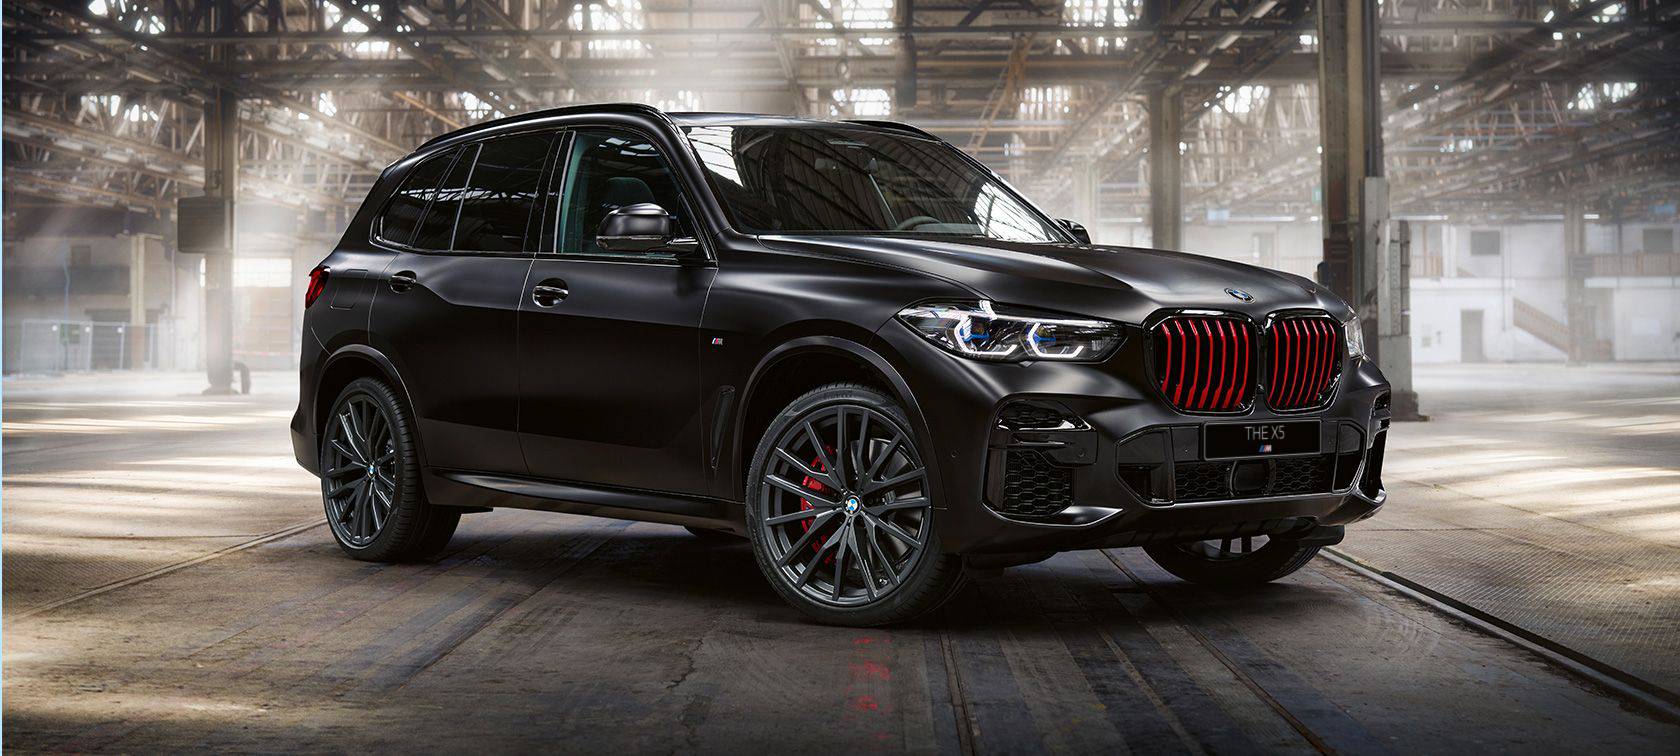

Данные подготовлены к обучению. На данном этапе производится обучение моделей, проверка моделей на адекватность и их сравнение.

## LightGBM model

In [8]:
lgb_train = lgb.Dataset(features_train, target_train)
lgb_eval = lgb.Dataset(features_valid, target_valid, reference=lgb_train)

params = {
    'boosting_type': 'dart',
    'max_depth': 19,
    'max_bin': 5000,
    'objective': 'regression',
    'metric': {'mean_absolute_error'},
    'num_leaves': 20,
    'min_gain_to_split': 0.2,
    'min_sum_hessian_in_leaf': 1,
    'min_data_in_leaf': 1,
    'learning_rate': 0.3,
    'feature_fraction': 0.6,
    'bagging_fraction': 1,
    'bagging_freq': 5,
    'num_iterations': 500,
    'verbose': -1
}

print('Training LightGBM model...')

gbm = lgb.train(params,
                lgb_train,
                num_boost_round=10,
                valid_sets=lgb_eval,
                early_stopping_rounds=20,
                verbose_eval=False)

print('Training is done.')
print('-'*90)
print('Validation LightGBM model...')
print('-'*90)
print('Validate LightGBM model metrics:')
predictions_valid = gbm.predict(features_valid, num_iteration=gbm.best_iteration)
rmse_valid = mean_squared_error(target_valid, predictions_valid) ** 0.5
print('The RMSE of prediction is: {:.2f}'.format(rmse_valid))
print('The MAE of prediction is: {:.2f}'.format(mean_absolute_error(target_valid, predictions_valid)))

Training LightGBM model...
Training is done.
------------------------------------------------------------------------------------------
Validation LightGBM model...
------------------------------------------------------------------------------------------
Validate LightGBM model metrics:
The RMSE of prediction is: 669416.81
The MAE of prediction is: 230471.12


Метрика MAE на валидационной выборке для модели LightGBM составила: 230471.12

## Random Forest model

In [9]:
%%time

best_result = 10000000

print('------ Обучение RandomForest ------')
print()

for est in range(40, 51, 10):
    for depth in range (11, 13):
        model = RandomForestRegressor(random_state=12345, n_estimators=est, max_depth=depth)
        model.fit(features_train, target_train)
        predictions_valid = model.predict(features_valid)
        result = mean_absolute_error(target_valid, predictions_valid)
        if result < best_result:
            best_model_rand_forest = model
            best_result = result
            best_est = est
            best_depth = depth
        print('MAE on valid set: {:.2f}'.format(result))

print("MAE наилучшей модели на валидационной выборке:", best_result, "Количество деревьев:", best_est, "Максимальная глубина:", depth, sep='\n')

------ Обучение RandomForest ------

MAE on valid set: 370744.86
MAE on valid set: 350305.13
MAE on valid set: 372033.56
MAE on valid set: 351301.34
MAE наилучшей модели на валидационной выборке:
350305.12766094785
Количество деревьев:
40
Максимальная глубина:
12
Wall time: 2min


Метрика MAE на валидационной выборке для модели Random Forest составила: 350305 

Рассмотрим влияние признаков.

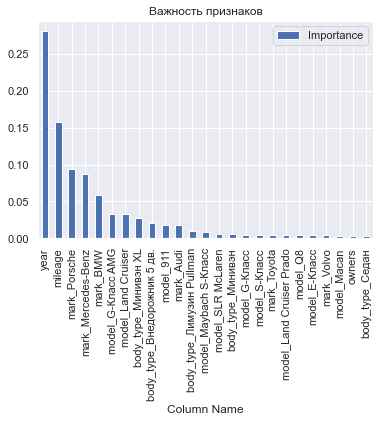

In [10]:
features_columns = pd.DataFrame(features_test.columns, columns = ['Column Name'])
features_imp = pd.DataFrame(best_model_rand_forest.feature_importances_, columns = ['Importance'])
imp = features_columns.join(features_imp)
imp = imp.sort_values(by='Importance', ascending=False)[:25]
imp.set_index('Column Name').plot(kind='bar', title='Важность признаков');

Количество владельцев уходит на задний план когда речь заходит о таких дорогих марках как <b>Porsche, Mercedes Benz, BMW</b>

Год выпуска и пробег по прежнему остаются на первом месте по влиянию.

## RandomSearch LightGBM

In [11]:
mini = 99999999999999999999999 
count = 0 #Used for keeping track of the iteration number
#How many runs to perform using randomly selected hyperparameters
iterations = 50
for i in range(iterations):
    print('iteration number', count)
    count += 1 #increment count
    try:
        d_train = lgb.Dataset(features_train, label=target_train) #Load in data
        params = {} #initialize parameters
        params['learning_rate'] = np.random.uniform(0, 1)
        params['boosting_type'] = np.random.choice(['gbdt', 'dart', 'goss'])
        params['objective'] = 'regression'
        params['metric'] = 'mae'
        params['verbose'] = -1
        params['feature_pre_filter'] = False
        params['sub_feature'] = np.random.uniform(0, 1)
        params['num_leaves'] = np.random.randint(20, 150)
        params['min_data'] = np.random.randint(10, 50)
        params['max_depth'] = np.random.randint(5, 50)
        iterations = np.random.randint(10, 100)
        #print(params, iterations)

        clf = lgb.train(params, d_train, iterations, verbose_eval=False)
        predictions_valid = clf.predict(features_valid) #Create predictions on test set
        mae = mean_absolute_error(predictions_valid, target_valid)
        print('MAE:', mae, ' with iterations', iterations)
        if mae < mini:
            mini = mae
            pp = params 
    except:
        print('failed with')
        print(params)
print("*" * 50)
print('Minimum MAE is: ', mini)
print('Used params: ', pp)

iteration number 0
MAE: 438928.1742024698  with iterations 12
iteration number 1
MAE: 306137.9722784324  with iterations 29
iteration number 2
MAE: 492497.34685165895  with iterations 24
iteration number 3
MAE: 317038.0281620455  with iterations 57
iteration number 4
MAE: 372745.69008324126  with iterations 71
iteration number 5
MAE: 315137.04558149114  with iterations 52
iteration number 6
MAE: 365030.9968121048  with iterations 83
iteration number 7
MAE: 397749.73540905927  with iterations 36
iteration number 8
MAE: 450009.3819424101  with iterations 44
iteration number 9
MAE: 299004.8010396343  with iterations 91
iteration number 10
MAE: 408892.75392613077  with iterations 15
iteration number 11
MAE: 529185.6329783421  with iterations 97
iteration number 12
MAE: 392696.7594529478  with iterations 54
iteration number 13
MAE: 317674.3330632282  with iterations 23
iteration number 14
MAE: 373784.1015022536  with iterations 76
iteration number 15
MAE: 325775.40374783  with iterations 85

RandomSearch LightGBM показал метрику MAE на валидационной выборке равной: 273257

In [12]:
rs_gbm = lgb.train(pp, d_train, iterations, verbose_eval=False)

## Gradient Boosting Regressor

In [13]:
gbr = GradientBoostingRegressor(n_estimators=300, learning_rate=0.8, max_depth=8, subsample=0.9)
gbr.fit(features_train, target_train)

gbr_predictions_train = gbr.predict(features_train)
print('MAE of GradientBoostingRegressor | (train) |', mean_absolute_error(target_train, gbr_predictions_train))
print('RMSE of GradientBoostingRegressor | (train) |', mean_squared_error(target_train, gbr_predictions_train) ** 0.5)
gbr_predictions_valid = gbr.predict(features_valid)
print('MAE of GradientBoostingRegressor | (test) |', mean_absolute_error(target_valid, gbr_predictions_valid))
print('RMSE of GradientBoostingRegressor | (test) |', mean_squared_error(target_valid, gbr_predictions_valid) ** 0.5)

MAE of GradientBoostingRegressor | (train) | 63610.87357770436
RMSE of GradientBoostingRegressor | (train) | 115641.93577348629
MAE of GradientBoostingRegressor | (test) | 281861.1008485367
RMSE of GradientBoostingRegressor | (test) | 774443.8248340687


Метрика MAE на валидационной выборке для модели Gradient Boosting Regressor составила: 275631

## Адекватность модели

In [14]:
fiction = pd.Series()
for row in range(target_valid.shape[0]):
    fiction.loc[row] = target_valid.median()
fiction_test = pd.Series()
for row in range(target_test.shape[0]):
    fiction_test.loc[row] = target_test.median()

print('MAE на валидационной выборке:', mean_absolute_error(fiction, target_valid))
print('MAE на тестовой выборке:', mean_absolute_error(fiction_test, target_test))

MAE на валидационной выборке: 988704.9362174154
MAE на тестовой выборке: 982470.5393040344


Метрика MAE при заполнении цен средним значением составила примерно 988000, это говорит о том, что все модели прошли тест на адекватность.

## Сравнение моделей

Перейдем к сравнению моделей, будем сравнивать их на тестовой выборке.

,MAE,RMSE
Random Forest,345045.23,650198.08
Gradient Boosting Regressor,280471.08,671940.27
LightGBM,222970.96,475206.27
RandomSearch LightGBM,293070.93,674138.56


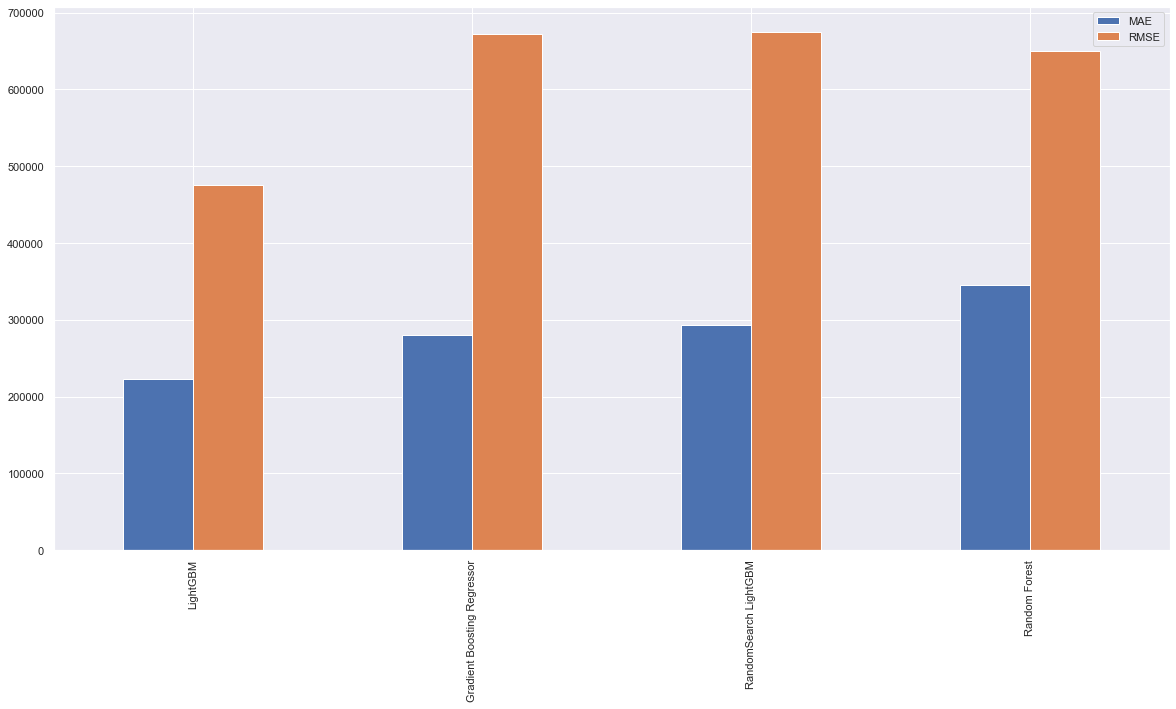

In [15]:
def test_model(model, features_test, target_test):
    predictions = model.predict(features_test)
    mae = mean_absolute_error(predictions, target_test)
    rmse = mean_squared_error(predictions, target_test) ** 0.5
    return float('{:.2f}'.format(mae)), float('{:.2f}'.format(rmse))

models = [best_model_rand_forest, gbr, gbm, rs_gbm]
models_names = ['Random Forest', 'Gradient Boosting Regressor', 'LightGBM', 'RandomSearch LightGBM']
maes = []

for model in models:
    maes.append(test_model(model, features_test, target_test))
    
scores = pd.DataFrame(maes, columns=['MAE', 'RMSE'], index=models_names)
scores.sort_values(by='MAE', ascending=True).plot(kind='bar', figsize=(20, 10));
scores

Наименьшая MAE у модели LightGBM. Данная модель будет выбрана для оценки автомобилей.

## Ввод данных для оценки

In [24]:
owners = input('Введите количество владельцев (целое число): ')
year = input('Введите год выпуска автомобиля (целое число): ')
dealer = input('Продажа автомобиля от салона (да) или от собственника (нет): ')
if dealer == 'да':
    dealer = True 
else: 
    dealer = False
region = input('Введите регион продажи автомобиля: ')
mileage = input('Введите пробег автомобиля в километрах (целое число): ')
section = input('Автомобиль новый (да) или б/у (нет): ')
if section == 'да':
    section = 'new'
else:
    section = 'used'
vendor = input('Введите страну производства (JAPANESE, EUROPEAN, KOREAN, AMERICAN, RUSSIAN): ')
body_type = input('Введите тип кузова авто (Внедорожник 5 дв., Седан, Купе, Лифтбек, Минивэн, Хэтчбэк 5 дв., Родстер, Универсал 5 дв., Кабриолет, Хэтчбэк 3 дв.): ')
mark = input('Введите марку авто (Mercedes-Benz, BMW, Hyundai, Kia, Volkswagen, Toyota, Nissan, Renault, Audi, Suzuki, Opel, Skoda, Volvo, Mazda, Ford, Mitsubishi, Honda, Porsche): ')
model = input('Введите модель авто: ')

Введите количество владельцев (целое число): 2
Введите год выпуска автомобиля (целое число): 2007
Продажа автомобиля от салона (да) или от собственника (нет): нет
Введите регион продажи автомобиля: Москва
Введите пробег автомобиля в километрах (целое число): 100000
Автомобиль новый (да) или б/у (нет): нет
Введите страну производства (JAPANESE, EUROPEAN, KOREAN, AMERICAN, RUSSIAN): JAPANESE
Введите тип кузова авто (Внедорожник 5 дв., Седан, Купе, Лифтбек, Минивэн, Хэтчбэк 5 дв., Родстер, Универсал 5 дв., Кабриолет, Хэтчбэк 3 дв.): Седан
Введите марку авто (Mercedes-Benz, BMW, Hyundai, Kia, Volkswagen, Toyota, Nissan, Renault, Audi, Suzuki, Opel, Skoda, Volvo, Mazda, Ford, Mitsubishi, Honda, Porsche): Toyota
Введите модель авто: Camry


In [32]:
trying = pd.DataFrame({'owners': owners, 'year': year, 'dealer': dealer, 'region': region, 'mileage': mileage,
              'section': section, 'vendor': vendor, 'body_type': body_type, 'mark': mark, 'model': model}, index=[1])
trying[num_cols] = scaler.transform(trying[num_cols])
d = pd.get_dummies(trying, columns=['dealer', 'region', 'section', 'vendor', 'body_type', 'mark', 'model'])
m = features_test.merge(d, how='outer')
m.loc[7213]
predictions_new = gbm.predict(m.loc[7213])

print('Примерная цена вашего автомобиля составляет: {:.0f} руб.'.format(predictions_new[0]))

Примерная цена вашего автомобиля составляет: 864501 руб.


Похожий по характеристикам автомобиль на auto.ru

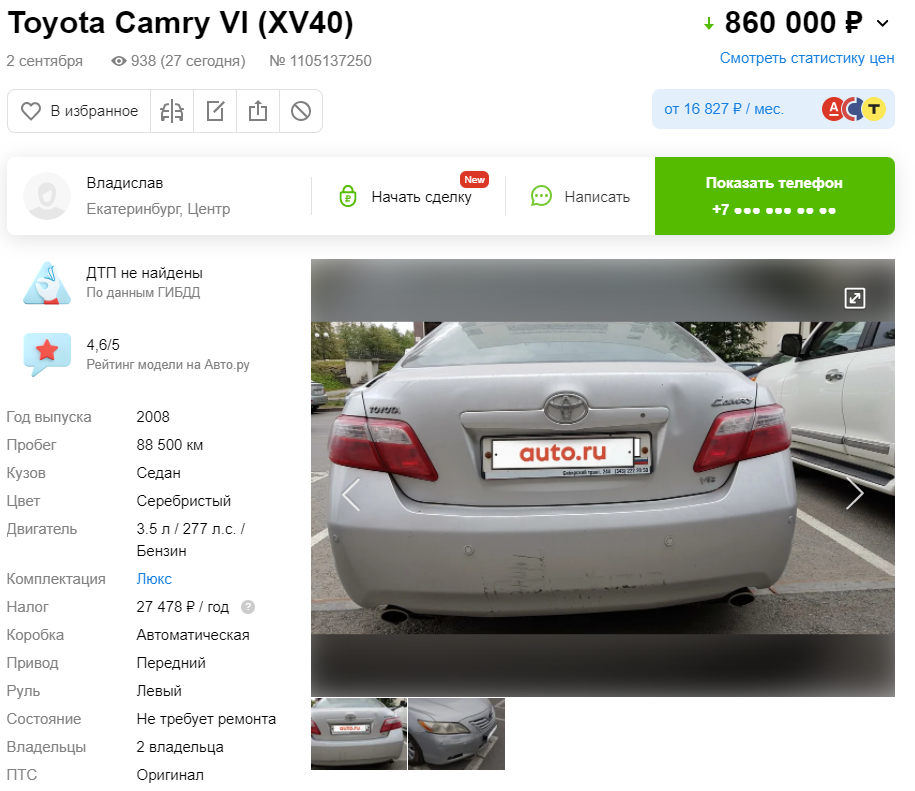